# Librerias & Recursos

In [2]:
%pip install pandas numpy unidecode nltk spacy matplotlib wordcloud scikit-learn tensorflow openpyxl pyarrow

# Descargar el modelo de lenguaje de spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.1 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
import spacy
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

2025-04-21 03:29:08.725808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 03:29:09.134526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 03:29:09.270053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745206149.451431   53845 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745206149.613371   53845 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745206150.191933   53845 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
# Asegurarse de que tengamos los recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Carga de Datasets

In [5]:
twitter_df = pd.read_csv('Data/Tweet_Post.csv')
twitter_df.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [6]:
# cargar dataset parquet en pandas
parquet_file = pd.read_parquet('Data/test-00000-of-00001-d161e0d7d20a9b0a.parquet')
travel_df = pd.DataFrame(parquet_file)
travel_df.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


In [7]:
neutral_df = pd.read_csv('Data/neutral.csv')
neutral_df.head()

,post,sentiment
0,"La película estuvo más o menos, ni me encantó ...",Neutral
1,"El servicio en el restaurante fue regular, lo ...",Neutral
2,"La calidad del producto es del montón, cumple ...",Neutral
3,"El hotel estaba bien, nada especial pero tampo...",Neutral
4,"La experiencia fue normal, como en cualquier o...",Neutral


In [8]:
neutral_df.shape

(2813, 2)

In [9]:
# contar los valores unicos en la columna post de neutral1_df
neutral_df['post'].nunique()

2307

# Descripción de los datos

In [10]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   object
 1   text       2590 non-null   object
 2   date       2590 non-null   object
 3   emotion    2590 non-null   object
 4   sentiment  2590 non-null   object
dtypes: object(5)
memory usage: 101.3+ KB


In [11]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25171 entries, 0 to 25170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25171 non-null  object
 1   label   25171 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 393.4+ KB


In [12]:
neutral_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2813 entries, 0 to 2812
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post       2813 non-null   object
 1   sentiment  2813 non-null   object
dtypes: object(2)
memory usage: 44.1+ KB


In [13]:
# guardar neutral_df en csv
neutral_df.to_csv('Data/neutral.csv', index=False)

# Pre procesamiento

## Mapear etiquetas de sentimentos segun el modelo de Sentimiento de Plutchik

In [14]:
twitter_selected = twitter_df[['text', 'sentiment']].copy()
twitter_selected.rename(columns={'text': 'post'}, inplace=True)
twitter_selected['source'] = 'Twitter'
twitter_selected.head()

,post,sentiment,source
0,termine bien abrumado después de hoy,scared,Twitter
1,me siento abrumado,scared,Twitter
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter
3,Salvador la única persona que no la ha abrumad...,scared,Twitter
4,Denme un helado o algo que ando full abrumado.,scared,Twitter


In [15]:
travel_selected = travel_df.copy()
travel_selected.rename(columns={'text': 'post', 'label': 'sentiment'}, inplace=True)
travel_selected['source'] = 'Review'
travel_selected.head()

,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review
3,Monserrate y sus bellas vistas Es una visita o...,5,Review
4,Un paraiso muy cerca de la ciudad de Mérida El...,5,Review


In [16]:
# 2 registros del dataset de la columna post, donde sentiment = 1, que se vea completo la columna post
display(travel_selected[travel_selected['sentiment'] == 1].head(2))
display(travel_selected[travel_selected['sentiment'] == 2].head(2))
display(travel_selected[travel_selected['sentiment'] == 3].head(2))
display(travel_selected[travel_selected['sentiment'] == 4].head(2))
display(travel_selected[travel_selected['sentiment'] == 5].head(2))

,post,sentiment,source
43,Pésima opción entre servicio e instalaciones N...,1,Review
79,Aburrido Me enteré a través del museo entero c...,1,Review


,post,sentiment,source
11,"Buena comida, pero ten paciencia Este fue el p...",2,Review
87,"horrible sucio, descuidado, abandonado, muy fe...",2,Review


,post,sentiment,source
9,Información poco clara. Lugar agradable Cierra...,3,Review
19,Comida decepcionante Reservamos una mesa aquí ...,3,Review


,post,sentiment,source
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
8,Buen hotel para negocios La ubicacion del hote...,4,Review


,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review


In [17]:
# Mapear los sentimientos según el modelo de Plutchik
# Plutchik tiene 8 emociones básicas: alegría, confianza, miedo, sorpresa, tristeza, disgusto, ira, anticipación
plutchik_mapping = {
    # Twitter emotions
    'scared': 'Miedo',
    'sad': 'Tristeza',  
    'powerful': 'Confianza',
    'peaceful': 'Satisfaccion',  # Podría mapearse a "confianza" en un nivel menor de intensidad
    'mad': 'Ira',
    'joyful': 'Alegria',   

    # Hotel ratings (1-5)
    1: 'Ira',      # Rating 1: Muy negativo, muestra ira/enojo
    2: 'Tristeza',    # Rating 2: Negativo, muestra disgusto, tristeza
    3: 'Satisfaccion',    # Rating 3: Mixto o neutral
    4: 'Alegria',        # Rating 4: Positivo, muestra alegría
    5: 'Confianza'       # Rating 5: Muy positivo, muestra confianza/admiración
}

# Aplicar mapping a los sentimientos en ambos datasets
twitter_selected['plutchik_sentiment'] = twitter_selected['sentiment'].map(plutchik_mapping)
travel_selected['plutchik_sentiment'] = travel_selected['sentiment'].map(plutchik_mapping)


print("\nResultados Mapeo de Twitter_df")
print(twitter_selected[['sentiment', 'plutchik_sentiment']].value_counts())
print("\nResultados Mapeo de TRavel_df")
print(travel_selected[['sentiment', 'plutchik_sentiment']].value_counts())


Resultados Mapeo de Twitter_df
sentiment  plutchik_sentiment
peaceful   Satisfaccion          660
mad        Ira                   530
powerful   Confianza             420
sad        Tristeza              360
joyful     Alegria               350
scared     Miedo                 270
Name: count, dtype: int64

Resultados Mapeo de TRavel_df
sentiment  plutchik_sentiment
5          Confianza             15710
4          Alegria                6023
3          Satisfaccion           2166
2          Tristeza                695
1          Ira                     577
Name: count, dtype: int64


In [18]:
# Mapear los sentimientos según el modelo de Plutchik
# Plutchik tiene 8 emociones básicas: alegría, confianza, miedo, sorpresa, tristeza, disgusto, ira, anticipación
plutchik_mapping_2_em = {
    # Twitter emotions
    'scared': 'Negativa',
    'sad': 'Negativa',
    'powerful': 'Positiva',
    'peaceful': 'Positiva',  # Podría mapearse a "confianza" en un nivel menor de intensidad
    'mad': 'Negativa',
    'joyful': 'Positiva',   

    # Hotel ratings (1-5)
    1: 'Negativa',      # Rating 1: Muy negativo, muestra ira/enojo
    2: 'Negativa',    # Rating 2: Negativo, muestra disgusto, tristeza
    3: 'Positiva',    # Rating 3: Mixto o neutral
    4: 'Positiva',        # Rating 4: Positivo, muestra alegría
    5: 'Positiva'       # Rating 5: Muy positivo, muestra confianza/admiración
}

# Aplicar mapping a los sentimientos en ambos datasets
twitter_selected['2_sentiment'] = twitter_selected['sentiment'].map(plutchik_mapping_2_em)
travel_selected['2_sentiment'] = travel_selected['sentiment'].map(plutchik_mapping_2_em)


print("\nResultados Mapeo de Twitter_df")
print(twitter_selected[['sentiment', '2_sentiment']].value_counts())
print("\nResultados Mapeo de TRavel_df")
print(travel_selected[['sentiment', '2_sentiment']].value_counts())


Resultados Mapeo de Twitter_df
sentiment  2_sentiment
peaceful   Positiva       660
mad        Negativa       530
powerful   Positiva       420
sad        Negativa       360
joyful     Positiva       350
scared     Negativa       270
Name: count, dtype: int64

Resultados Mapeo de TRavel_df
sentiment  2_sentiment
5          Positiva       15710
4          Positiva        6023
3          Positiva        2166
2          Negativa         695
1          Negativa         577
Name: count, dtype: int64


## Balanceo de clases

In [19]:
def graficar_balance_clases(dataset, nombre, columna_sentimiento, palette=None):
    """
    Grafica el balance de clases de una columna de sentimientos en un dataset.

    Parámetros:
    - dataset: DataFrame que contiene los datos.
    - nombre: Nombre del dataset (para el título de la gráfica).
    - columna_sentimiento: Nombre de la columna que contiene los sentimientos.
    - palette: Diccionario con los colores para cada sentimiento (opcional).
    """
    # Verificar el balance de clases
    class_counts = dataset[columna_sentimiento].value_counts()
    print(f"\nConteo de clases en el dataset: {nombre}")
    print(class_counts)

    # Filtrar las categorías que existen en el dataset
    if palette:
        existing_categories = [cat for cat in palette.keys() if cat in class_counts.index]
        palette = {cat: palette[cat] for cat in existing_categories}
    else:
        existing_categories = class_counts.index.tolist()

    # Graficar el balance de clases
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
        data=dataset,
        x=columna_sentimiento,
        palette=palette,  # Usar la paleta personalizada si se proporciona
        order=existing_categories  # Ordenar según las categorías existentes
    )

    # Añadir las cantidades encima de cada barra
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
            textcoords='offset points'
        )

    # Añadir título y etiquetas
    plt.title(f'Balance de Clases en el Dataset {nombre}', fontsize=16, fontweight='bold')
    plt.xlabel('Sentimiento', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)

    # Mejorar la visualización de los ejes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Mostrar la gráfica
    plt.show()

In [20]:
# balanceo de las clases sin eliminar ninguna clase solo reduciendo el número de ejemplos de la clase mayoritaria
def balance_classes(df, target_col):
    # Obtener el conteo de cada clase
    class_counts = df

    class_counts = df[target_col].value_counts()
    min_count = class_counts.min()
    print(f"Conteo mínimo de clases: {min_count}")
    print(f"Conteo de clases antes del balanceo:\n{class_counts}")

    # Crear un nuevo DataFrame para almacenar los datos balanceados
    balanced_df = pd.DataFrame()
    for sentiment in class_counts.index:
        # Filtrar los ejemplos de la clase actual
        class_df = df[df[target_col] == sentiment]
        
        # Si la clase tiene más ejemplos que el mínimo, reducir su tamaño
        if len(class_df) > min_count:
            class_df = class_df.sample(min_count, random_state=42)
        
        # Añadir los ejemplos balanceados al DataFrame final
        balanced_df = pd.concat([balanced_df, class_df], ignore_index=True)
            
    # Reiniciar el índice del DataFrame balanceado
    balanced_df.reset_index(drop=True, inplace=True)
    
    # Mostrar el conteo de clases después del balanceo
    print(f"\nConteo de clases después del balanceo:\n{balanced_df[target_col].value_counts()}")
    
    return balanced_df

In [21]:
# Definir la paleta de colores según el modelo de Plutchik
plutchik_mapping_3_em = {
    "Positiva": "yellow",
    "Negativa": "lightcoral",
    "Neutral": "lightblue",
}

plutchik_mapping = {
    "Alegria": "yellow",       # Alegria
    "Confianza": "green",     # Confianza
    "Miedo": "purple",          # Miedo
    "Satisfaccion": "orange",     # Satisfaccion
    "Tristeza": "lightblue", # Tristeza
    "Ira": "red",             # Ira
}

### Tres Emociones

In [22]:
# Balancear las clases del DataFrame de viajes
travel_balanced_3em = balance_classes(travel_selected, '2_sentiment')

Conteo mínimo de clases: 1272
Conteo de clases antes del balanceo:
2_sentiment
Positiva    23899
Negativa     1272
Name: count, dtype: int64

Conteo de clases después del balanceo:
2_sentiment
Positiva    1272
Negativa    1272
Name: count, dtype: int64


In [23]:
# Merge los dos datasets
merge_2em_df = pd.concat([twitter_selected[['post','2_sentiment']], travel_balanced_3em[['post','2_sentiment']]], ignore_index=True)
merge_2em_df = merge_2em_df.rename(columns={'2_sentiment': 'sentiment'})
merge_3em_df = pd.concat([merge_2em_df, neutral_df], ignore_index=True)

# Reset index
merge_2em_df.reset_index(drop=True, inplace=True)

# Check merged dataset
print("\nIngformación Merged Dataset:")
print(merge_2em_df.info())
print("\nPrimeras filas del Merged Dataset:")
merge_2em_df.head()


Ingformación Merged Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post       5134 non-null   object
 1   sentiment  5134 non-null   object
dtypes: object(2)
memory usage: 80.3+ KB
None

Primeras filas del Merged Dataset:


,post,sentiment
0,termine bien abrumado después de hoy,Negativa
1,me siento abrumado,Negativa
2,Me siento un poco abrumado por la cantidad de ...,Negativa
3,Salvador la única persona que no la ha abrumad...,Negativa
4,Denme un helado o algo que ando full abrumado.,Negativa



Conteo de clases en el dataset: Análisis Sentimientos
sentiment
Positiva    2702
Negativa    2432
Name: count, dtype: int64


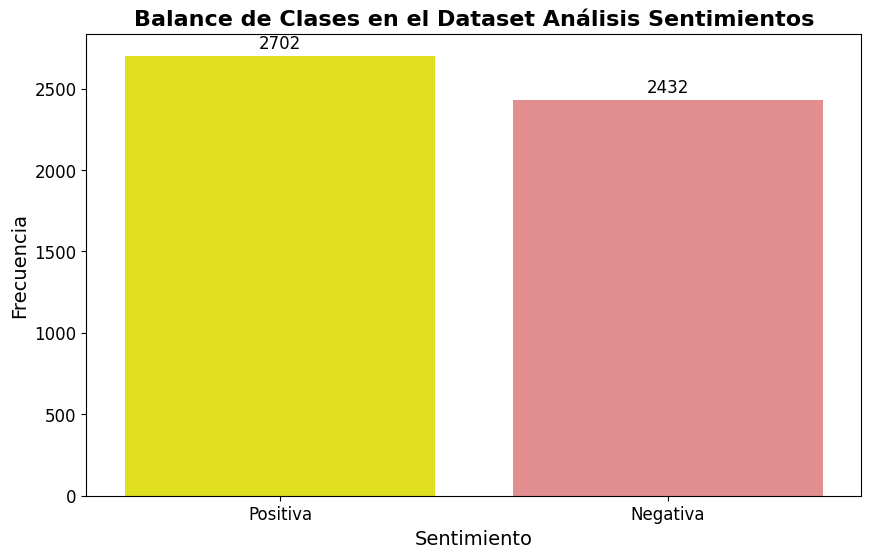

In [136]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(merge_2em_df, 'Análisis Sentimientos','sentiment', palette=plutchik_mapping_3_em)


Conteo de clases en el dataset: Análisis Sentimientos
sentiment
Neutral     2813
Positiva    2702
Negativa    2432
Name: count, dtype: int64


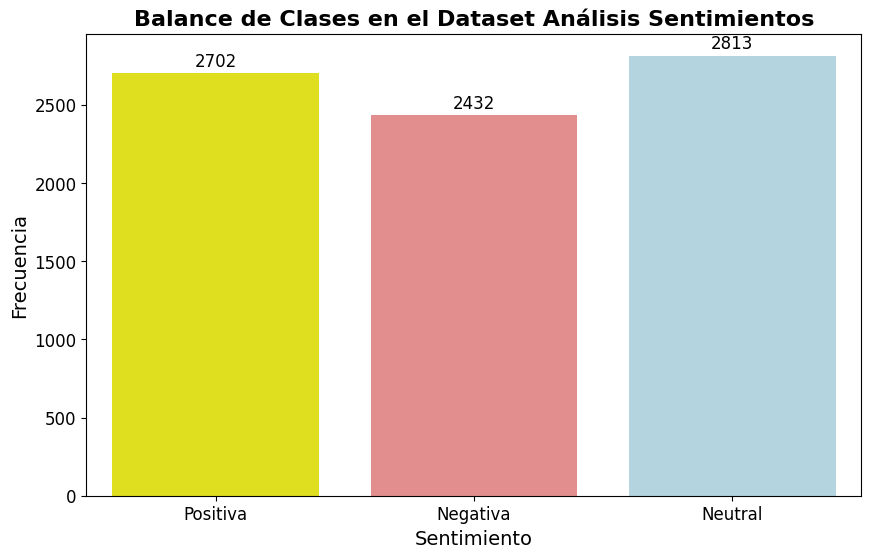

In [137]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(merge_3em_df, 'Análisis Sentimientos','sentiment', palette=plutchik_mapping_3_em)

### Todas las Emociones


Conteo de clases en el dataset: twitter_df
plutchik_sentiment
Satisfaccion    660
Ira             530
Confianza       420
Tristeza        360
Alegria         350
Miedo           270
Name: count, dtype: int64


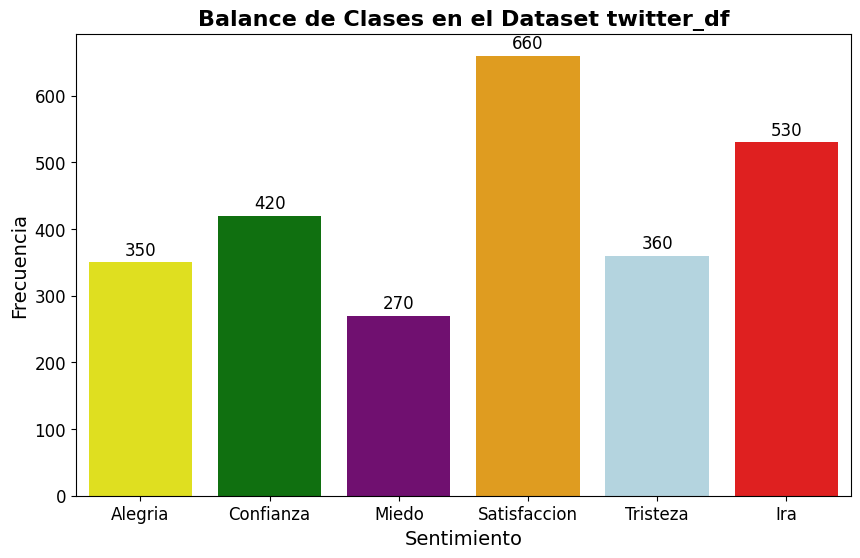

In [138]:
# Verificar el balance de clases en twitter_df
graficar_balance_clases(twitter_selected, 'twitter_df', 'plutchik_sentiment', palette=plutchik_mapping)


Conteo de clases en el dataset: travel_df
plutchik_sentiment
Confianza       15710
Alegria          6023
Satisfaccion     2166
Tristeza          695
Ira               577
Name: count, dtype: int64


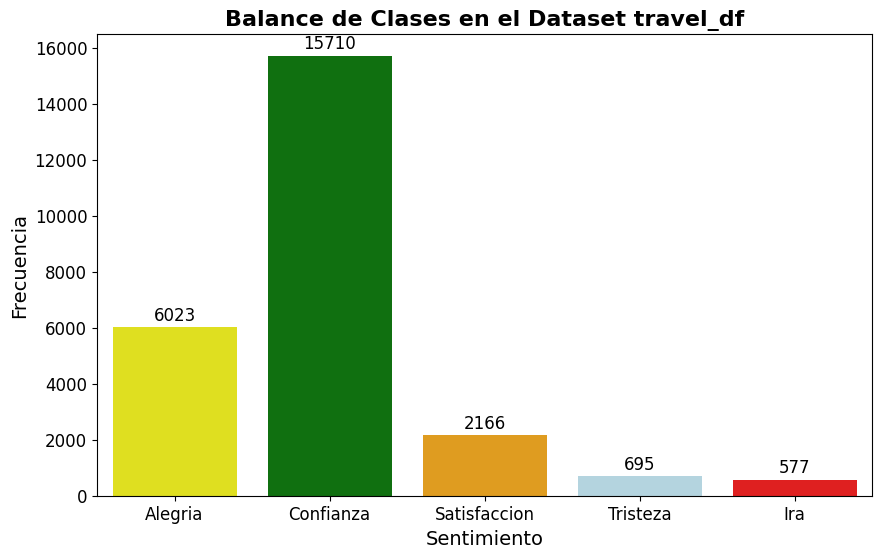

In [139]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(travel_selected,'travel_df','plutchik_sentiment', palette=plutchik_mapping)

In [140]:
# Balancear las clases del DataFrame de viajes
travel_balanced_em = balance_classes(travel_selected, 'plutchik_sentiment')

Conteo mínimo de clases: 577
Conteo de clases antes del balanceo:
plutchik_sentiment
Confianza       15710
Alegria          6023
Satisfaccion     2166
Tristeza          695
Ira               577
Name: count, dtype: int64

Conteo de clases después del balanceo:
plutchik_sentiment
Confianza       577
Alegria         577
Satisfaccion    577
Tristeza        577
Ira             577
Name: count, dtype: int64


In [141]:
travel_balanced_em['plutchik_sentiment'].value_counts()

plutchik_sentiment
Confianza       577
Alegria         577
Satisfaccion    577
Tristeza        577
Ira             577
Name: count, dtype: int64

In [142]:
# Merge los dos datasets
merged_em_df = pd.concat([twitter_selected, travel_balanced_em], ignore_index=True)

# Reset index
merged_em_df.reset_index(drop=True, inplace=True)

# Check merged dataset
print("\nIngformación Merged Dataset:")
print(merged_em_df.info())
print("\nPrimeras filas del Merged Dataset:")
merged_em_df.head()


Ingformación Merged Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   post                5475 non-null   object
 1   sentiment           5475 non-null   object
 2   source              5475 non-null   object
 3   plutchik_sentiment  5475 non-null   object
 4   2_sentiment         5475 non-null   object
dtypes: object(5)
memory usage: 214.0+ KB
None

Primeras filas del Merged Dataset:


,post,sentiment,source,plutchik_sentiment,2_sentiment
0,termine bien abrumado después de hoy,scared,Twitter,Miedo,Negativa
1,me siento abrumado,scared,Twitter,Miedo,Negativa
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter,Miedo,Negativa
3,Salvador la única persona que no la ha abrumad...,scared,Twitter,Miedo,Negativa
4,Denme un helado o algo que ando full abrumado.,scared,Twitter,Miedo,Negativa



Conteo de clases en el dataset: merged_em_df
plutchik_sentiment
Satisfaccion    1237
Ira             1107
Confianza        997
Tristeza         937
Alegria          927
Miedo            270
Name: count, dtype: int64


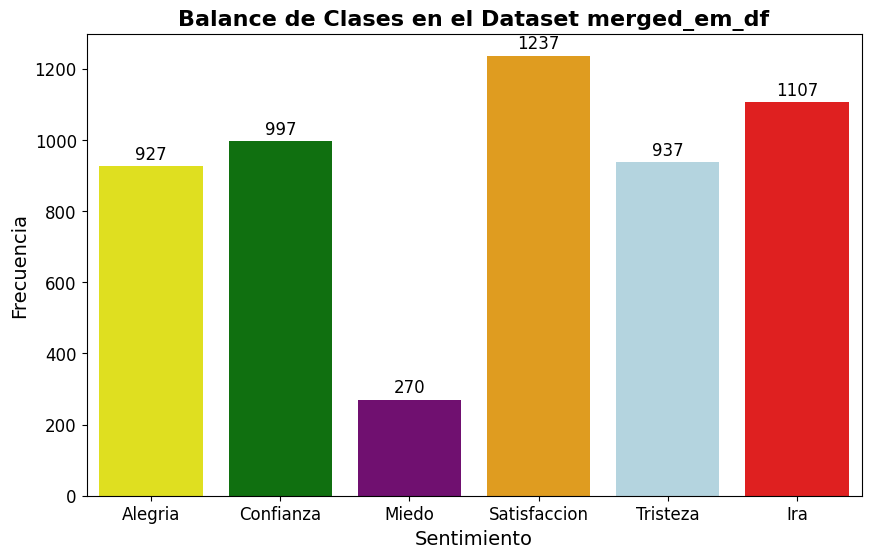

In [143]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(merged_em_df, 'merged_em_df','plutchik_sentiment', palette=plutchik_mapping)

## Transformación del texto

In [24]:
def normalize_text(text):
    """
    Normalize text by:
    1. Removing special characters (keeping Spanish letters and accents)
    2. Removing words with characters repeated more than twice
    3. Joining hyphenated words
    4. Converting to lowercase
    5. Removing tildes and the letter "ñ"
    """
    if not isinstance(text, str):
        return ""
    
    # Remove tildes and the letter "ñ" using unidecode
    text = unidecode(text)
    
    # Remove special characters (keeping only letters and spaces)
    letters_only = re.sub(r"[^A-Za-z\s]", " ", text)
    
    # Remove repeated characters (more than 2 times)
    no_repeats = re.sub(r"(.)\1{2,}", r"\1\1", letters_only)
    
    # Join hyphenated words
    no_hyphens = re.sub(r"([A-Za-z]+)-([A-Za-z]+)", r"\1\2", no_repeats)
    
    # Convert to lowercase
    lowercase = no_hyphens.lower()
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", lowercase).strip()
    
    return cleaned

In [25]:
merge_3em_df['normalized_text'] = merge_3em_df['post'].apply(normalize_text)

merge_2em_df['normalized_text'] = merge_2em_df['post'].apply(normalize_text)
print("\nEjemplos Normalizacion:")
for i in range(min(5, len(merge_2em_df))):
    print(f"Original: {merge_2em_df.loc[i, 'post']}")
    print(f"Normalizado: {merge_2em_df.loc[i, 'normalized_text']}")
    print("-" * 50)


Ejemplos Normalizacion:
Original: termine bien abrumado después de hoy
Normalizado: termine bien abrumado despues de hoy
--------------------------------------------------
Original: me siento abrumado
Normalizado: me siento abrumado
--------------------------------------------------
Original: Me siento un poco abrumado por la cantidad de cosas que quiero dibujar, ver, jugar y leer. Odio esta sensación xdddd
Normalizado: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
--------------------------------------------------
Original: Salvador la única persona que no la ha abrumado de versiones❤😒❤ #NadieComoTú
Normalizado: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
--------------------------------------------------
Original: Denme un helado o algo que ando full abrumado.
Normalizado: denme un helado o algo que ando full abrumado
--------------------------------------------------


In [26]:
def tokenize_text(text):
    """
    Tokenize text into individual words
    """
    if not isinstance(text, str) or not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens

In [27]:
# Apply tokenization to the normalized text
merge_3em_df['tokens'] = merge_3em_df['normalized_text'].apply(tokenize_text)

merge_2em_df['tokens'] = merge_2em_df['normalized_text'].apply(tokenize_text)

# Show examples of tokenization
print("\nEjemplo Tokenizacion:")
for i in range(min(5, len(merge_2em_df))):
    print(f"Normalized: {merge_2em_df.loc[i, 'normalized_text']}")
    print(f"Tokens: {merge_2em_df.loc[i, 'tokens']}")
    print("-" * 50)


Ejemplo Tokenizacion:
Normalized: termine bien abrumado despues de hoy
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
--------------------------------------------------
Normalized: me siento abrumado
Tokens: ['me', 'siento', 'abrumado']
--------------------------------------------------
Normalized: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
--------------------------------------------------
Normalized: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
--------------------------------------------------
Normalized: denme un helado o algo que ando full abrumado
Tokens: ['denme', 'un',

In [28]:
def remove_stopwords(tokens):
    """
    Remove Spanish stopwords from a list of tokens
    """
    if not tokens:
        return []
    
    spanish_stopwords = set(stopwords.words('spanish'))
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    return filtered_tokens

In [29]:
# Apply stopword removal to the tokens
merge_3em_df['filtered_tokens'] = merge_3em_df['tokens'].apply(remove_stopwords)

merge_2em_df['filtered_tokens'] = merge_2em_df['tokens'].apply(remove_stopwords)

# Show examples of stopword removal
print("\nEjemplos Remocion Stopword:")
for i in range(min(5, len(merge_2em_df))):
    print(f"Tokens: {merge_2em_df.loc[i, 'tokens']}")
    print(f"Despues de remover Stopword: {merge_2em_df.loc[i, 'filtered_tokens']}")
    print("-" * 50)


Ejemplos Remocion Stopword:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
Despues de remover Stopword: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
--------------------------------------------------
Tokens: ['me', 'siento', 'abrumado']
Despues de remover Stopword: ['siento', 'abrumado']
--------------------------------------------------
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
Despues de remover Stopword: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
Despues de remover Stopword: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
------------------------------------

In [30]:
try:
    nlp = spacy.load('es_core_news_sm')
except:
    # If model not found, download it
    import sys
    !{sys.executable} -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

def lemmatize_tokens(tokens):
    """
    Lemmatize a list of tokens using spaCy's Spanish model
    """
    if not tokens:
        return []
    
    # Join tokens back into text for spaCy processing
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Extract lemmas
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.strip()]
    
    return lemmas

In [31]:
# Apply lemmatization to the filtered tokens
merge_3em_df['lemmas'] = merge_3em_df['filtered_tokens'].apply(lemmatize_tokens)

merge_2em_df['lemmas'] = merge_2em_df['filtered_tokens'].apply(lemmatize_tokens)

# Show examples of lemmatization
print("\nEjemplos Lemmatizacion:")
for i in range(min(5, len(merge_2em_df))):
    print(f"Tokens: {merge_2em_df.loc[i, 'filtered_tokens']}")
    print(f"Lemmas: {merge_2em_df.loc[i, 'lemmas']}")
    print("-" * 50)


Ejemplos Lemmatizacion:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
Lemmas: ['terminar', 'bien', 'abrumado', 'despu', 'hoy']
--------------------------------------------------
Tokens: ['siento', 'abrumado']
Lemmas: ['sentir', 'abrumado']
--------------------------------------------------
Tokens: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
Lemmas: ['sentir', 'abrumado', 'cantidad', 'cosa', 'querer', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
Lemmas: ['salvador', 'unico', 'persona', 'abrumado', 'versión', 'nadiecomotu']
--------------------------------------------------
Tokens: ['denme', 'helado', 'ando', 'full', 'abrumado']
Lemmas: ['denmir', 'helado', 'ar', 'full', 'abrumado']
--------------------------------------------------


In [32]:
# Combinar lemmas en un solo string para cada fila
merge_3em_df['clean_text'] = merge_3em_df['lemmas'].apply(lambda x: ' '.join(x) if x else '')
merge_2em_df['clean_text'] = merge_2em_df['lemmas'].apply(lambda x: ' '.join(x) if x else '')

\Generando Word Cloud para los Textos:


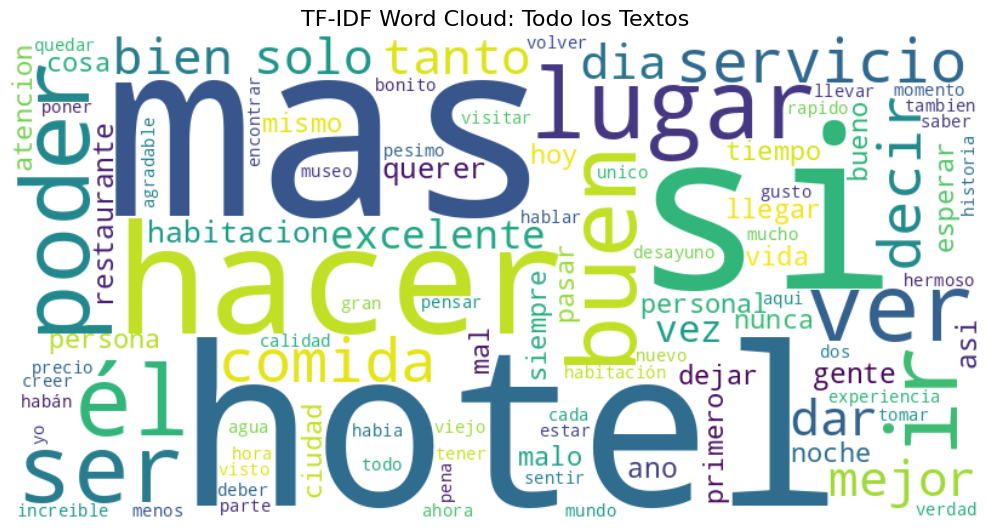

In [153]:
# Create a TF-IDF word cloud for each sentiment category

# Create a function to generate word clouds from TF-IDF values
def generate_tfidf_wordcloud(texts, title, max_words=100):
    """
    Generate a word cloud based on TF-IDF values for a collection of texts
    """
    # Create a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    
    # Fit and transform the texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    # Get feature names and their TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF values across documents for each word
    tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create a dictionary of word -> TF-IDF score
    word_tfidf = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(word_tfidf)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate a word cloud for all texts
print("\Generando Word Cloud para los Textos:")
all_texts = merge_2em_df['clean_text'].tolist()
generate_tfidf_wordcloud(all_texts, 'TF-IDF Word Cloud: Todo los Textos')


Generando Word Clouds por Categorias de Sentimiento:


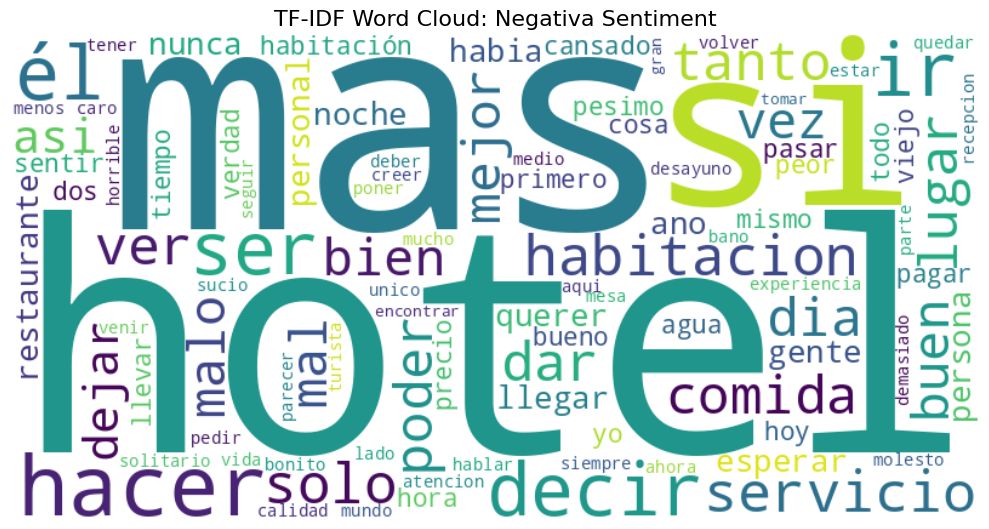

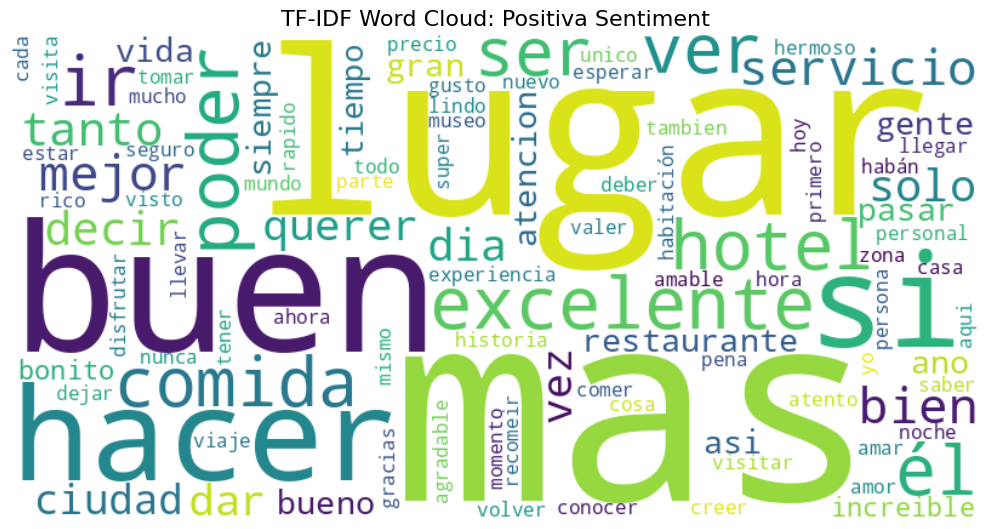

In [154]:
# Generate word clouds for each sentiment category
print("\nGenerando Word Clouds por Categorias de Sentimiento:")
for sentiment in merge_2em_df['sentiment'].dropna().unique():
    sentiment_texts = merge_2em_df[merge_2em_df['sentiment'] == sentiment]['clean_text'].dropna().tolist()
    if sentiment_texts:
        generate_tfidf_wordcloud(sentiment_texts, f'TF-IDF Word Cloud: {sentiment.title()} Sentiment')

In [155]:
# Final processed dataset summary
print("\nResumen Final")
print(f"Numero total de post: {len(merge_2em_df)}")
print(f"Numero de post por sentimiento: {merge_2em_df['sentiment'].value_counts().to_dict()}")


Resumen Final
Numero total de post: 5134
Numero de post por sentimiento: {'Positiva': 2702, 'Negativa': 2432}


In [33]:
merge_2em_df.head()

,post,sentiment,normalized_text,tokens,filtered_tokens,lemmas,clean_text
0,termine bien abrumado después de hoy,Negativa,termine bien abrumado despues de hoy,"[termine, bien, abrumado, despues, de, hoy]","[termine, bien, abrumado, despues, hoy]","[terminar, bien, abrumado, despu, hoy]",terminar bien abrumado despu hoy
1,me siento abrumado,Negativa,me siento abrumado,"[me, siento, abrumado]","[siento, abrumado]","[sentir, abrumado]",sentir abrumado
2,Me siento un poco abrumado por la cantidad de ...,Negativa,me siento un poco abrumado por la cantidad de ...,"[me, siento, un, poco, abrumado, por, la, cant...","[siento, abrumado, cantidad, cosas, quiero, di...","[sentir, abrumado, cantidad, cosa, querer, dib...",sentir abrumado cantidad cosa querer dibujar v...
3,Salvador la única persona que no la ha abrumad...,Negativa,salvador la unica persona que no la ha abrumad...,"[salvador, la, unica, persona, que, no, la, ha...","[salvador, unica, persona, abrumado, versiones...","[salvador, unico, persona, abrumado, versión, ...",salvador unico persona abrumado versión nadiec...
4,Denme un helado o algo que ando full abrumado.,Negativa,denme un helado o algo que ando full abrumado,"[denme, un, helado, o, algo, que, ando, full, ...","[denme, helado, ando, full, abrumado]","[denmir, helado, ar, full, abrumado]",denmir helado ar full abrumado


In [157]:
merge_3em_df.head()

,post,sentiment,normalized_text,tokens,filtered_tokens,lemmas,clean_text
0,termine bien abrumado después de hoy,Negativa,termine bien abrumado despues de hoy,"[termine, bien, abrumado, despues, de, hoy]","[termine, bien, abrumado, despues, hoy]","[terminar, bien, abrumado, despu, hoy]",terminar bien abrumado despu hoy
1,me siento abrumado,Negativa,me siento abrumado,"[me, siento, abrumado]","[siento, abrumado]","[sentir, abrumado]",sentir abrumado
2,Me siento un poco abrumado por la cantidad de ...,Negativa,me siento un poco abrumado por la cantidad de ...,"[me, siento, un, poco, abrumado, por, la, cant...","[siento, abrumado, cantidad, cosas, quiero, di...","[sentir, abrumado, cantidad, cosa, querer, dib...",sentir abrumado cantidad cosa querer dibujar v...
3,Salvador la única persona que no la ha abrumad...,Negativa,salvador la unica persona que no la ha abrumad...,"[salvador, la, unica, persona, que, no, la, ha...","[salvador, unica, persona, abrumado, versiones...","[salvador, unico, persona, abrumado, versión, ...",salvador unico persona abrumado versión nadiec...
4,Denme un helado o algo que ando full abrumado.,Negativa,denme un helado o algo que ando full abrumado,"[denme, un, helado, o, algo, que, ando, full, ...","[denme, helado, ando, full, abrumado]","[denmir, helado, ar, full, abrumado]",denmir helado ar full abrumado


# Funciones para metricas

In [50]:
def report_classification_metrics(y_test, y_pred, target_names):
    """
    Report classification metrics including accuracy, precision, recall, and F1-score.

    Parameters:
    - y_test: True labels for the test set.
    - y_pred: Predicted labels for the test set.
    - target_names: List of target class names.
    """
    
    # Predicciones y reporte de clasificación
    print(classification_report(y_test, y_pred, target_names=target_names))

    #matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# 3 Sentimientos

In [159]:
# Split
X = merge_3em_df['normalized_text']
X

0                    termine bien abrumado despues de hoy
1                                      me siento abrumado
2       me siento un poco abrumado por la cantidad de ...
3       salvador la unica persona que no la ha abrumad...
4           denme un helado o algo que ando full abrumado
                              ...                        
7942                           el local resulto aceptable
7943    el espectaculo lo encontre del monton personal...
7944                   la capacidad se mantuvo suficiente
7945    el mantenimiento estaba aceptable personalment...
7946    el articulo es apenas tolerable por otra parte...
Name: normalized_text, Length: 7947, dtype: object

In [160]:
y = merge_3em_df['sentiment']
y

0       Negativa
1       Negativa
2       Negativa
3       Negativa
4       Negativa
          ...   
7942     Neutral
7943     Neutral
7944     Neutral
7945     Neutral
7946     Neutral
Name: sentiment, Length: 7947, dtype: object

## Redes Neuronales

In [161]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
# Convertir etiquetas a formato numérico
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [163]:
num_classes

3

In [164]:
# Configuración para tokenización y secuencias
max_words = 15000
max_length = 150
embedding_dim = 256

In [165]:
# Crear y ajustar tokenizador
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [166]:
# Convertir textos a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [167]:
# Padding para tener secuencias de igual longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [168]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

2025-04-21 02:33:22.932220: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [169]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [170]:
# Entrenar el modelo
history = model.fit(
    X_train_pad, y_train_encoded,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 712ms/step - accuracy: 0.5946 - loss: 0.8903 - val_accuracy: 0.6588 - val_loss: 0.5190
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 131s 734ms/step - accuracy: 0.6823 - loss: 0.5408 - val_accuracy: 0.7767 - val_loss: 0.4589
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 700ms/step - accuracy: 0.8503 - loss: 0.3971 - val_accuracy: 0.8538 - val_loss: 0.3625
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 688ms/step - accuracy: 0.9455 - loss: 0.2108 - val_accuracy: 0.8601 - val_loss: 0.3793
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 691ms/step - accuracy: 0.9676 - loss: 0.1414 - val_accuracy: 0.8758 - val_loss: 0.4132
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 697ms/step - accuracy: 0.9845 - loss: 0.0953 - val_accuracy: 0.8569 - val_loss: 0.5372
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 698ms/step - accuracy: 0.9856 - loss: 0.0843 - val_accuracy: 0.8585 - val_loss: 0.5640
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 694ms/step - accuracy: 0.9931 -

In [172]:
y_pred_classes = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_classes, axis=1)
y_pred_classes

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step


array([2, 2, 1, ..., 1, 1, 0])

In [173]:
accuracy_LSM = accuracy_score(y_test_encoded, y_pred_classes)
accuracy_LSM

0.879245283018868

              precision    recall  f1-score   support

    Negativa       0.81      0.81      0.81       499
     Neutral       1.00      1.00      1.00       550
    Positiva       0.82      0.82      0.82       541

    accuracy                           0.88      1590
   macro avg       0.88      0.88      0.88      1590
weighted avg       0.88      0.88      0.88      1590



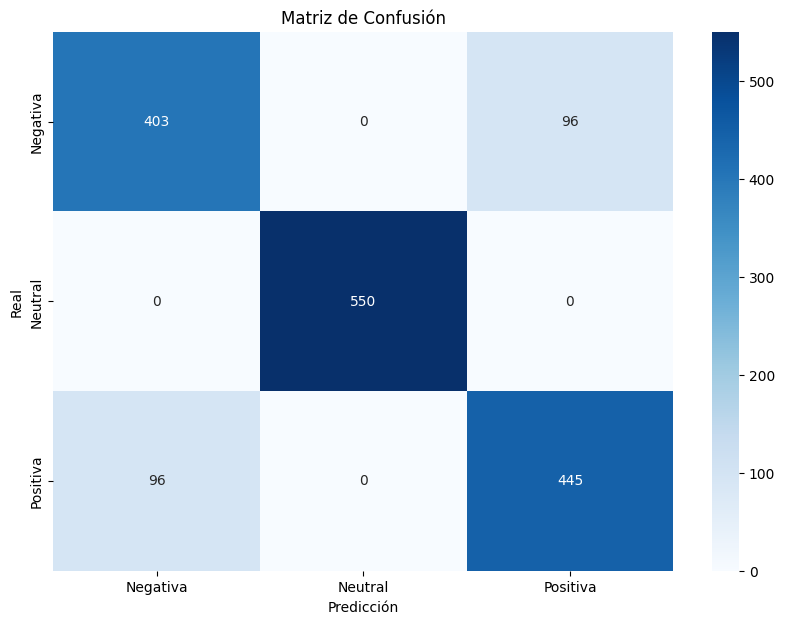

In [175]:
report_classification_metrics(y_test_encoded, y_pred_classes, label_encoder.classes_)

## Naive Bayes

In [176]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
# Inicializar el clasificador Naive Bayes
clf = MultinomialNB()
metric = 'accuracy'

In [178]:
# Definir el espacio de búsqueda de hiperparámetros
# alpha: parámetro de suavizado para manejar términos raros o ausentes
# fit_prior: determina si se aprenden las probabilidades previas de clase
parameters = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}

In [179]:
# Configuración del vectorizador TF-IDF
# Nota: Usamos los mismos parámetros que se mencionaban en el código anterior
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)

In [180]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")

Dimensiones de datos de entrenamiento: (6357, 5000)
Dimensiones de datos de prueba: (1590, 5000)


In [181]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring=metric, n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)


Realizando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Mejores hiperparámetros:
{'alpha': 0.01, 'fit_prior': True}


In [182]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: MultinomialNB(alpha={clf_best.alpha}, fit_prior={clf_best.fit_prior})")


Mejor modelo: MultinomialNB(alpha=0.01, fit_prior=True)


In [183]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [184]:
# Calcular exactitud (accuracy)
accuracy_NB = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_NB*100:.2f}%')


Exactitud (accuracy): 86.23%


In [185]:
# Evaluación del modelo
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

    Negativa       0.78      0.79      0.79       499
     Neutral       0.99      1.00      0.99       550
    Positiva       0.80      0.79      0.80       541

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



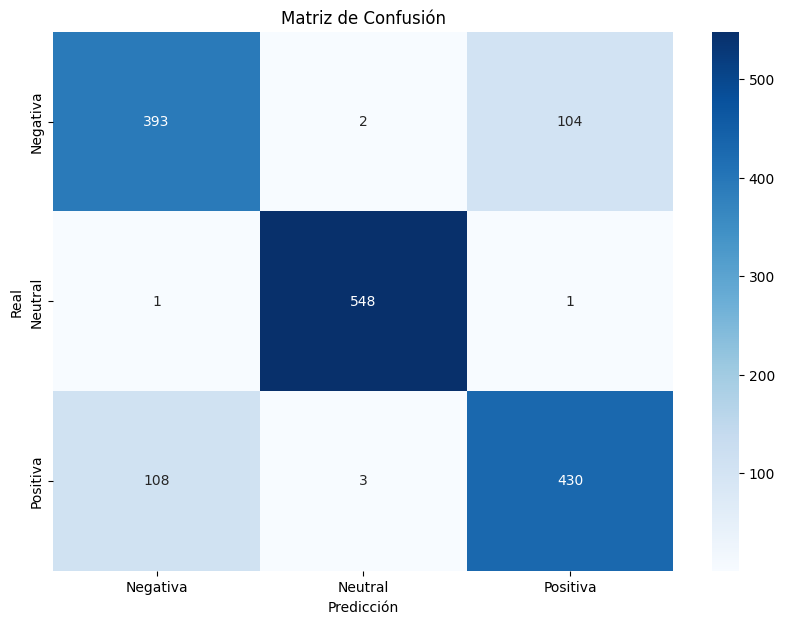

In [186]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

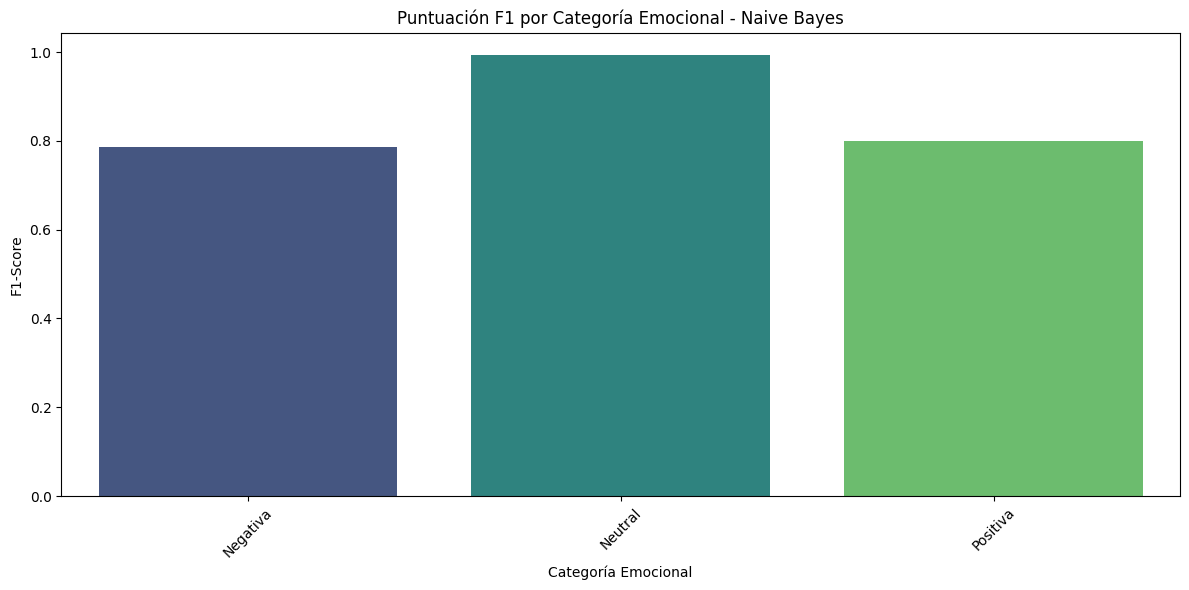

In [187]:
# Visualización del desempeño por clase
plt.figure(figsize=(12, 6))
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3]  # Eliminar filas de promedio
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.title('Puntuación F1 por Categoría Emocional - Naive Bayes')
plt.ylabel('F1-Score')
plt.xlabel('Categoría Emocional')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [188]:
# Análisis de características más importantes por clase
feature_names = tfidf_vectorizer.get_feature_names_out()
if hasattr(clf_best, 'feature_log_prob_'):
    n_top = 10  # Número de características principales a mostrar
    classes = sorted(np.unique(y_train))
    
    print("\nCaracterísticas más importantes por clase:")
    for i, class_label in enumerate(classes):
        # Obtener índices de las palabras con mayor probabilidad para esta clase
        top_indices = np.argsort(clf_best.feature_log_prob_[i])[-n_top:]
        top_features = [feature_names[j] for j in top_indices]
        
        print(f"\nClase: {class_label}")
        for j in range(n_top-1, -1, -1):  # Mostrar en orden descendente de importancia
            print(f"  {top_features[j]}")


Características más importantes por clase:

Clase: Negativa
  de
  que
  la
  no
  en
  el
  un
  me
  es
  por

Clase: Neutral
  ni
  el
  es
  la
  sin
  lo
  fue
  bien
  mas
  se

Clase: Positiva
  de
  que
  la
  en
  el
  un
  es
  muy
  con
  no


## Support Vector Machine (SVM)

In [189]:
# Inicializar el clasificador SVM con balanceo de clases
clf = SVC(class_weight='balanced', random_state=42)

In [190]:
# Definir el espacio de búsqueda de hiperparámetros
parameters = {
    'C': [0.1, 1, 1.2, 1.4, 1.5, 5, 9, 10],
    'gamma': [1e-3, 1e-2, 1e-1, 'auto'],  # 'auto' es 1/n_features
    'kernel': ['rbf', 'linear']
}

In [191]:
# Configuración del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)

In [192]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")

Dimensiones de datos de entrenamiento: (6357, 5000)
Dimensiones de datos de prueba: (1590, 5000)


In [193]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)


Realizando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Mejores hiperparámetros:
{'C': 9, 'gamma': 0.1, 'kernel': 'rbf'}


In [194]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: SVC(C={clf_best.C}, gamma={clf_best.gamma}, kernel='{clf_best.kernel}', class_weight='balanced')")



Mejor modelo: SVC(C=9, gamma=0.1, kernel='rbf', class_weight='balanced')


In [195]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [ ]:
# Calcular exactitud (accuracy)
accuracy_SVM = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_SVM*100:.2f}%')


Exactitud (accuracy): 84.23%


              precision    recall  f1-score   support

    Negativa       0.77      0.78      0.78       499
     Neutral       1.00      1.00      1.00       550
    Positiva       0.80      0.79      0.79       541

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



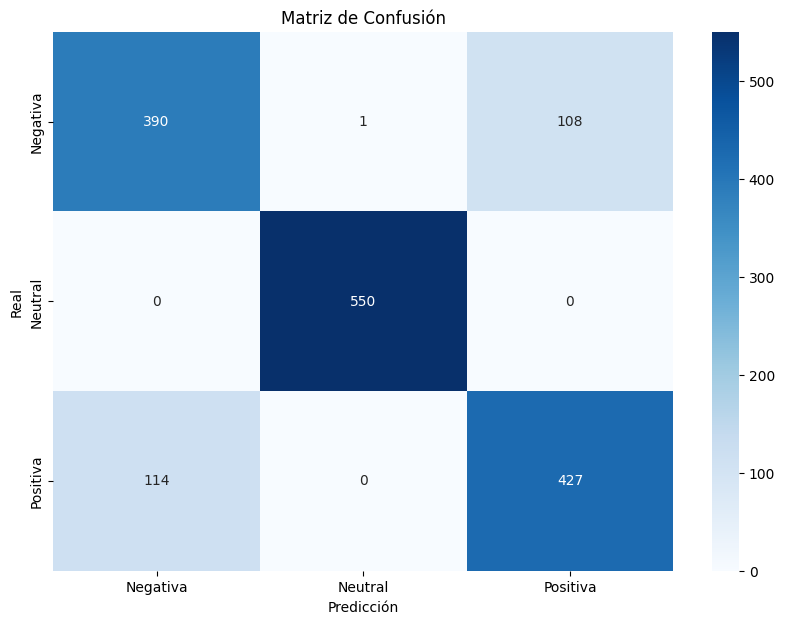

In [197]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

## Regresión Logística

In [198]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
# Inicializar el clasificador de regresión logística
clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

In [200]:
# Definir el espacio de búsqueda de hiperparámetros
parameters = {
    'C': [0.1, 1, 10, 100],  # Inverso de la regularización
    'solver': ['liblinear', 'saga'],  # Métodos de optimización
    'penalty': ['l2', 'elasticnet']  # Tipo de regularización
}

In [201]:
# Configuración del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")


Dimensiones de datos de entrenamiento: (6357, 5000)
Dimensiones de datos de prueba: (1590, 5000)


In [202]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)
# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)


Realizando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores hiperparámetros:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [203]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: LogisticRegression(C={clf_best.C}, solver='{clf_best.solver}', penalty='{clf_best.penalty}', class_weight='balanced')")


Mejor modelo: LogisticRegression(C=10, solver='liblinear', penalty='l2', class_weight='balanced')


In [204]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [ ]:
# Calcular exactitud (accuracy)
accuracy_Log = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_Log*100:.2f}%')



Exactitud (accuracy): 84.23%


              precision    recall  f1-score   support

    Negativa       0.78      0.78      0.78       499
     Neutral       0.99      1.00      1.00       550
    Positiva       0.80      0.79      0.80       541

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



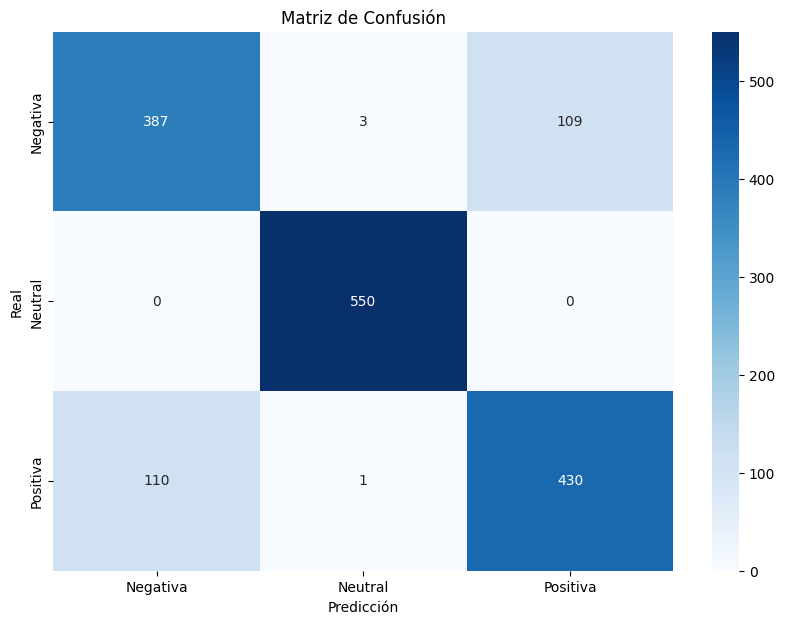

In [206]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

## Comparación resultados

In [207]:
def graph_compare_results(model_names, accuracies):
    # implementa un gráfico de barras con el eje x como los nombres de los modelos y el eje y como la exactitud, con lineas punteadas horizontales donde una exactitud <60% Bajo, entre 60% y 70% Medio y >70% Alto, cada barra tiene un porcentaje
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracies, palette='viridis')
    plt.ylim(0, 1)
    plt.axhline(y=0.6, color='red', linestyle='--', label='Bajo (<60%)')
    plt.axhline(y=0.7, color='orange', linestyle='--', label='Medio (60%-70%)')
    plt.axhline(y=0.8, color='green', linestyle='--', label='Alto (>80%)')
    plt.title('Comparación de Exactitud de Modelos de Clasificación')
    plt.ylabel('Exactitud')
    plt.xlabel('Modelo')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

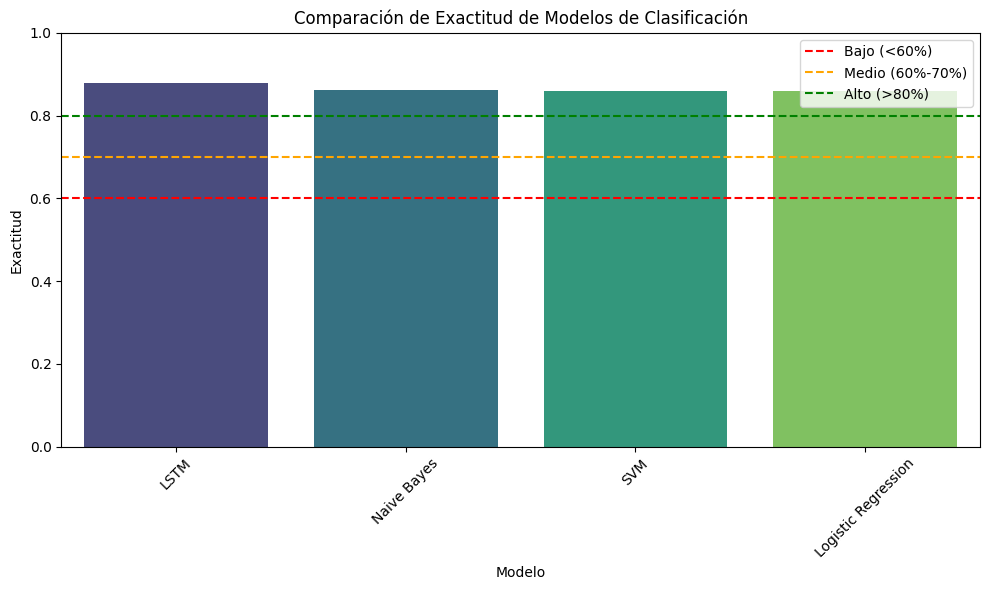

In [208]:
graph_compare_results(
    ['LSTM', 'Naive Bayes', 'SVM', 'Logistic Regression'],
    [accuracy_LSM, accuracy_NB, accuracy_SVM, accuracy_Log]
)

# 2 Sentimientos

In [34]:
# Split
X = merge_2em_df['normalized_text']
X

0                    termine bien abrumado despues de hoy
1                                      me siento abrumado
2       me siento un poco abrumado por la cantidad de ...
3       salvador la unica persona que no la ha abrumad...
4           denme un helado o algo que ando full abrumado
                              ...                        
5129    desastroso checking llegas al hotel despues de...
5130    mala atencion fuimos relegados y mal atendidos...
5131    no servia el teleferico fuimos hasta alla y al...
5132    no muy buenas vacaciones es un hotel pequeno e...
5133    decepcion la ubicacion es muy buena la atencio...
Name: normalized_text, Length: 5134, dtype: object

In [35]:
y = merge_2em_df['sentiment']
y

0       Negativa
1       Negativa
2       Negativa
3       Negativa
4       Negativa
          ...   
5129    Negativa
5130    Negativa
5131    Negativa
5132    Negativa
5133    Negativa
Name: sentiment, Length: 5134, dtype: object

## Redes Neuronales

In [36]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Convertir etiquetas a formato numérico
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [38]:
num_classes

2

In [39]:
# Configuración para tokenización y secuencias
max_words = 15000
max_length = 150
embedding_dim = 256

In [40]:
# Crear y ajustar tokenizador
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [42]:
# Convertir textos a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [43]:
# Padding para tener secuencias de igual longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [44]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

2025-04-21 03:33:50.282150: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [45]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [46]:
# Entrenar el modelo
history = model.fit(
    X_train_pad, y_train_encoded,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 96s 761ms/step - accuracy: 0.5459 - loss: 0.7620 - val_accuracy: 0.7129 - val_loss: 0.6133
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 739ms/step - accuracy: 0.8060 - loss: 0.4834 - val_accuracy: 0.8175 - val_loss: 0.4951
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 143s 749ms/step - accuracy: 0.9533 - loss: 0.1895 - val_accuracy: 0.8078 - val_loss: 0.5760
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 143s 755ms/step - accuracy: 0.9719 - loss: 0.1259 - val_accuracy: 0.8151 - val_loss: 0.6870
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 739ms/step - accuracy: 0.9848 - loss: 0.0832 - val_accuracy: 0.8029 - val_loss: 0.6378
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 143s 747ms/step - accuracy: 0.9880 - loss: 0.0711 - val_accuracy: 0.8200 - val_loss: 0.6745
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 739ms/step - accuracy: 0.9910 - loss: 0.0558 - val_accuracy: 0.8127 - val_loss: 0.6418
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 739ms/step - accuracy: 0.9906 - loss

In [47]:
y_pred_classes = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_classes, axis=1)
y_pred_classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step


array([0, 1, 1, ..., 0, 1, 1])

In [48]:
accuracy_LSM = accuracy_score(y_test_encoded, y_pred_classes)
accuracy_LSM

0.8403115871470301

              precision    recall  f1-score   support

    Negativa       0.85      0.82      0.84       514
    Positiva       0.83      0.86      0.84       513

    accuracy                           0.84      1027
   macro avg       0.84      0.84      0.84      1027
weighted avg       0.84      0.84      0.84      1027



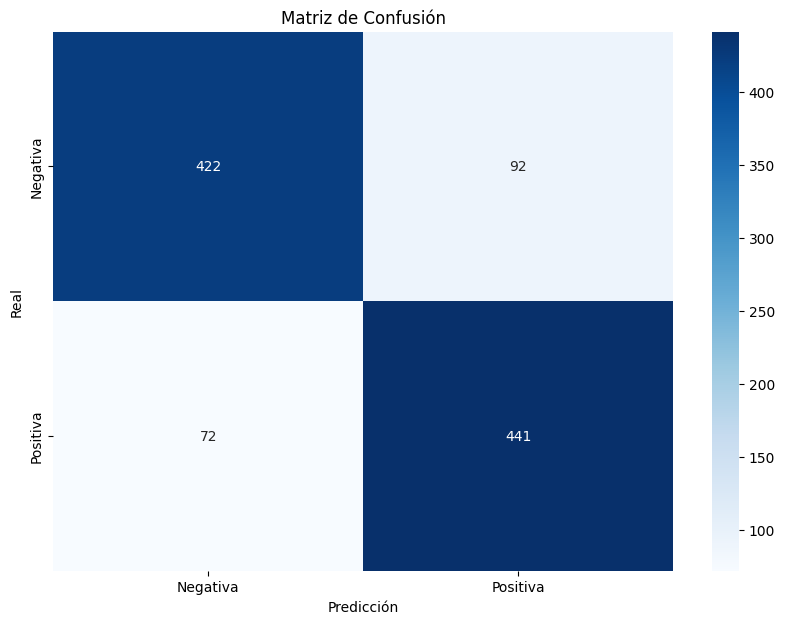

In [51]:
report_classification_metrics(y_test_encoded, y_pred_classes, label_encoder.classes_)

## Naive Bayes

In [52]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Inicializar el clasificador Naive Bayes
clf = MultinomialNB()
metric = 'accuracy'

In [54]:
# Definir el espacio de búsqueda de hiperparámetros
# alpha: parámetro de suavizado para manejar términos raros o ausentes
# fit_prior: determina si se aprenden las probabilidades previas de clase
parameters = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}

In [55]:
# Configuración del vectorizador TF-IDF
# Nota: Usamos los mismos parámetros que se mencionaban en el código anterior
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)

In [56]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")

Dimensiones de datos de entrenamiento: (4107, 5000)
Dimensiones de datos de prueba: (1027, 5000)


In [57]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring=metric, n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)


Realizando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 10 candidates, totalling 50 fits



Mejores hiperparámetros:
{'alpha': 0.01, 'fit_prior': True}


In [58]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: MultinomialNB(alpha={clf_best.alpha}, fit_prior={clf_best.fit_prior})")


Mejor modelo: MultinomialNB(alpha=0.01, fit_prior=True)


In [59]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [60]:
# Calcular exactitud (accuracy)
accuracy_NB = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_NB*100:.2f}%')


Exactitud (accuracy): 86.17%


In [61]:
# Evaluación del modelo
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

    Negativa       0.87      0.85      0.86       514
    Positiva       0.85      0.88      0.86       513

    accuracy                           0.86      1027
   macro avg       0.86      0.86      0.86      1027
weighted avg       0.86      0.86      0.86      1027



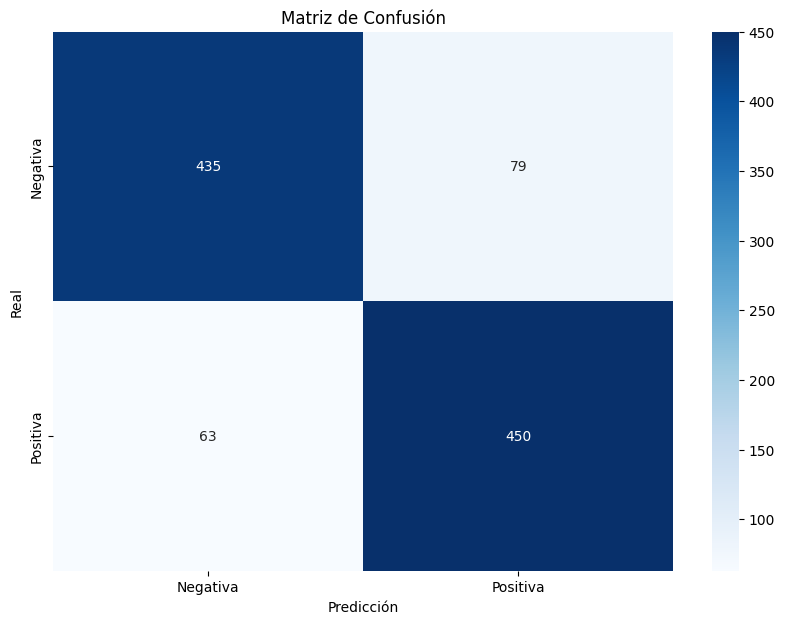

In [62]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

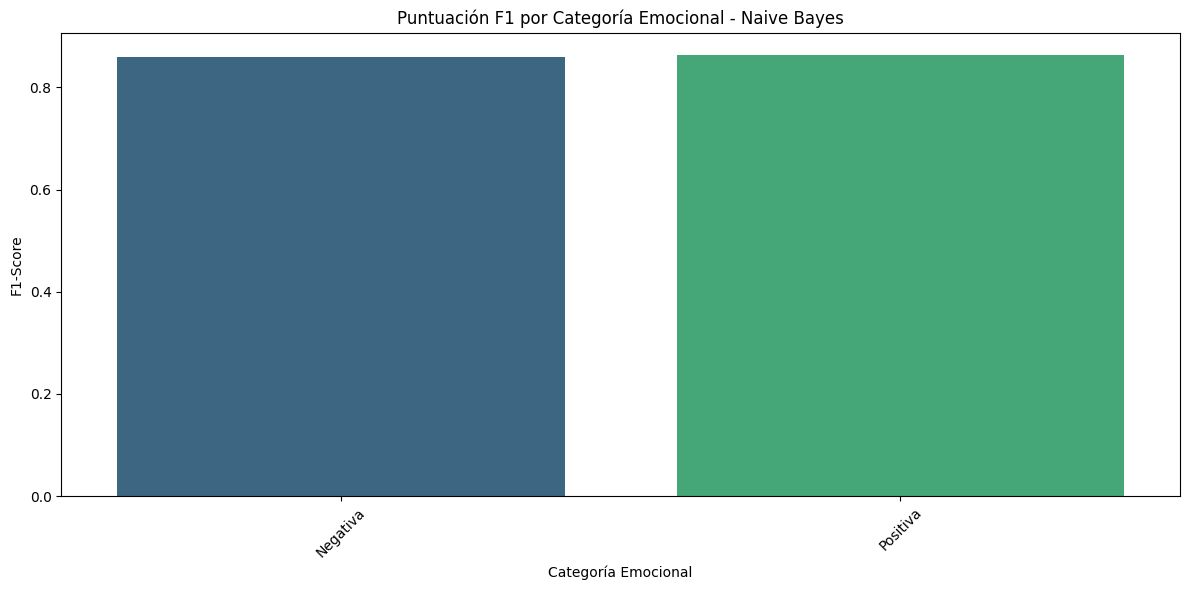

In [63]:
# Visualización del desempeño por clase
plt.figure(figsize=(12, 6))
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3]  # Eliminar filas de promedio
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.title('Puntuación F1 por Categoría Emocional - Naive Bayes')
plt.ylabel('F1-Score')
plt.xlabel('Categoría Emocional')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
# Análisis de características más importantes por clase
feature_names = tfidf_vectorizer.get_feature_names_out()
if hasattr(clf_best, 'feature_log_prob_'):
    n_top = 10  # Número de características principales a mostrar
    classes = sorted(np.unique(y_train))
    
    print("\nCaracterísticas más importantes por clase:")
    for i, class_label in enumerate(classes):
        # Obtener índices de las palabras con mayor probabilidad para esta clase
        top_indices = np.argsort(clf_best.feature_log_prob_[i])[-n_top:]
        top_features = [feature_names[j] for j in top_indices]
        
        print(f"\nClase: {class_label}")
        for j in range(n_top-1, -1, -1):  # Mostrar en orden descendente de importancia
            print(f"  {top_features[j]}")


Características más importantes por clase:

Clase: Negativa
  de
  que
  la
  el
  no
  en
  un
  es
  me
  se

Clase: Positiva
  de
  la
  que
  el
  en
  es
  un
  muy
  no
  con


## Support Vector Machine (SVM)

In [65]:
# Inicializar el clasificador SVM con balanceo de clases
clf = SVC(class_weight='balanced', random_state=42)

In [66]:
# Definir el espacio de búsqueda de hiperparámetros
parameters = {
    'C': [0.1, 1, 1.2, 1.4, 1.5, 5, 9, 10],
    'gamma': [1e-3, 1e-2, 1e-1, 'auto'],  # 'auto' es 1/n_features
    'kernel': ['rbf', 'linear']
}

In [67]:
# Configuración del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)

In [68]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")

Dimensiones de datos de entrenamiento: (4107, 5000)
Dimensiones de datos de prueba: (1027, 5000)


In [ ]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)

In [ ]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: SVC(C={clf_best.C}, gamma={clf_best.gamma}, kernel='{clf_best.kernel}', class_weight='balanced')")



Mejor modelo: SVC(C=1.2, gamma=0.001, kernel='linear', class_weight='balanced')


In [ ]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [ ]:
# Calcular exactitud (accuracy)
accuracy_SVM = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_SVM*100:.2f}%')


Exactitud (accuracy): 83.74%


              precision    recall  f1-score   support

    Negativa       0.85      0.82      0.83       514
    Positiva       0.83      0.86      0.84       513

    accuracy                           0.84      1027
   macro avg       0.84      0.84      0.84      1027
weighted avg       0.84      0.84      0.84      1027



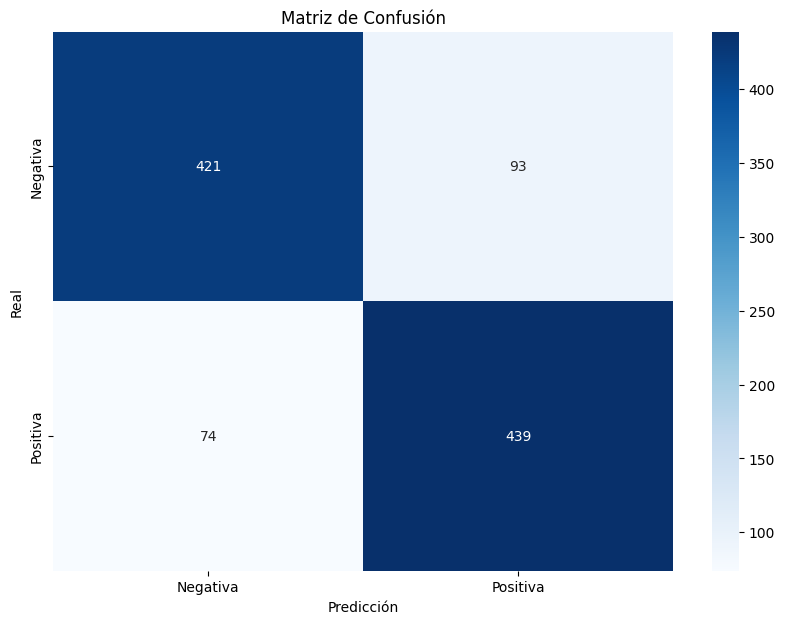

In [ ]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

## Regresión Logística

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Inicializar el clasificador de regresión logística
clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
parameters = {
    'C': [0.1, 1, 10, 100],  # Inverso de la regularización
    'solver': ['liblinear', 'saga'],  # Métodos de optimización
    'penalty': ['l2', 'elasticnet']  # Tipo de regularización
}

In [ ]:
# Configuración del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensiones de datos de entrenamiento: {X_train_tfidf.shape}")
print(f"Dimensiones de datos de prueba: {X_test_tfidf.shape}")


Dimensiones de datos de entrenamiento: (4107, 5000)
Dimensiones de datos de prueba: (1027, 5000)


In [ ]:
# Búsqueda de hiperparámetros óptimos
print("\nRealizando búsqueda de hiperparámetros óptimos...")
grid_search = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train_tfidf, y_train)
# Imprimir los mejores hiperparámetros
print('\nMejores hiperparámetros:')
print(grid_search.best_params_)


Realizando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores hiperparámetros:
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
# Obtener el mejor modelo
clf_best = grid_search.best_estimator_
print(f"\nMejor modelo: LogisticRegression(C={clf_best.C}, solver='{clf_best.solver}', penalty='{clf_best.penalty}', class_weight='balanced')")


Mejor modelo: LogisticRegression(C=10, solver='saga', penalty='l2', class_weight='balanced')


In [ ]:
# Realizar predicciones
y_pred = clf_best.predict(X_test_tfidf)

In [ ]:
# Calcular exactitud (accuracy)
accuracy_Log = accuracy_score(y_test, y_pred)
print(f'\nExactitud (accuracy): {accuracy_Log*100:.2f}%')



Exactitud (accuracy): 84.23%


              precision    recall  f1-score   support

    Negativa       0.86      0.82      0.84       514
    Positiva       0.83      0.86      0.85       513

    accuracy                           0.84      1027
   macro avg       0.84      0.84      0.84      1027
weighted avg       0.84      0.84      0.84      1027



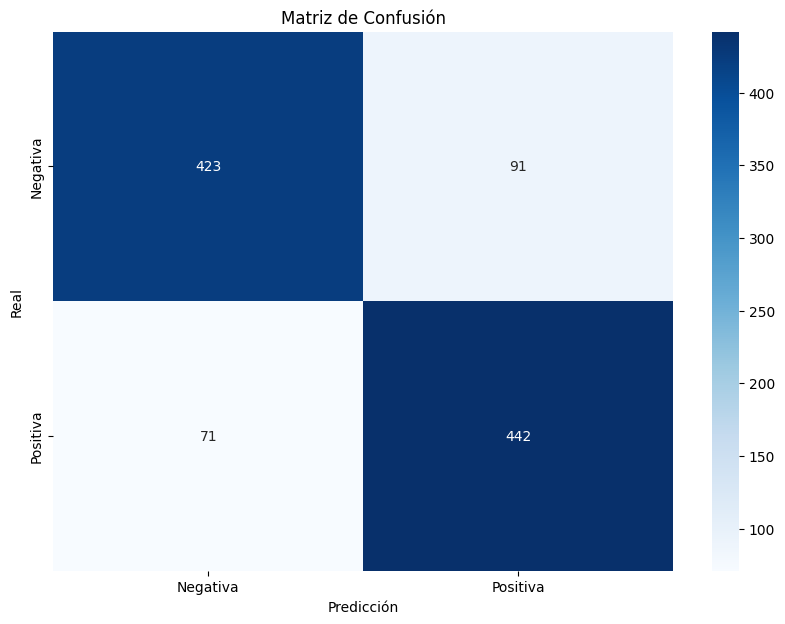

In [ ]:
report_classification_metrics(y_test, y_pred, np.unique(y_test))

## Comparación resultados

In [ ]:
def graph_compare_results(model_names, accuracies):
    # implementa un gráfico de barras con el eje x como los nombres de los modelos y el eje y como la exactitud, con lineas punteadas horizontales donde una exactitud <60% Bajo, entre 60% y 70% Medio y >70% Alto, cada barra tiene un porcentaje
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracies, palette='viridis')
    plt.ylim(0, 1)
    plt.axhline(y=0.6, color='red', linestyle='--', label='Bajo (<60%)')
    plt.axhline(y=0.7, color='orange', linestyle='--', label='Medio (60%-70%)')
    plt.axhline(y=0.8, color='green', linestyle='--', label='Alto (>80%)')
    plt.title('Comparación de Exactitud de Modelos de Clasificación')
    plt.ylabel('Exactitud')
    plt.xlabel('Modelo')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
graph_compare_results(
    ['LSTM', 'Naive Bayes', 'SVM', 'Logistic Regression'],
    [accuracy_LSM, accuracy_NB, accuracy_SVM, accuracy_Log]
)

NameError: name 'accuracy_LSM' is not defined